In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn import datasets
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.svm import SVR
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from datetime import datetime
import numpy as np
import lightgbm as lgb
import scipy
from scipy import stats
from sklearn.linear_model import Ridge

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_1 = pd.read_csv(".\\audiobooks.csv")
df_2 = pd.read_csv(".\\audiobooks_2.csv")
df = df_1.merge(df_2, on='audiobook_id')
df = df[['price', 'release_date', 'length', 'rating_overall', 'rating_performance', 'rating_story', 'author']].dropna()

def convert_time(time_str):
    year = time_str[-2:]
    time_str = time_str[:-2] + '20' + year
    date_time = datetime.strptime(time_str, '%m-%d-%Y')
    return date_time.timestamp()

def convert_duration(length):
    # 9 hrs and 15 mins
    
    if 'hrs' in length:
        hours = length.split('hrs')[0].strip() # 9
    else:
        hours = length.split('hr')[0].strip() # 9
    if 'mins' in length:
        minutes = length[:-5].split(' ')[-1] # 15
        time = int(hours)*60 + int(minutes)
    else:
        time = int(hours)*60
    return time

df['release_date'] = stats.zscore(df['release_date'].apply(convert_time))
df['length'] = stats.zscore(df['length'].apply(convert_duration))
df['price'] = df['price'].apply(lambda s : float(s[1:]))
df['rating_overall'] = stats.zscore(df['rating_overall'])

Poskusimo določiti spol avtorjev (bi imelo lahko to vpliv na uspešnost knjige?)

In [3]:
name_gender_dict = pd.read_csv(".\\name_gender_dataset.csv").drop_duplicates(subset=['Name']).set_index('Name').to_dict('index')
name_gender_dict
def find_gender(full_name):
    name = full_name.split(' ')[0]
    if name in name_gender_dict:
        gender = name_gender_dict[name]['Gender']
        if gender == 'M':
            return 0
        else:
            return 2
    else:
        return 1
        print('no match')

df['author_gender'] = stats.zscore(df['author'].apply(find_gender))
df

,price,release_date,length,rating_overall,rating_performance,rating_story,author,author_gender
0,25.51,0.757677,-0.496927,-0.275364,4.7,4.6,Matthew Perry,-0.799382
1,23.62,0.751481,-0.511563,0.211336,4.8,4.6,Colleen Hoover,1.372770
2,26.90,0.732950,1.180650,0.698036,4.9,4.7,Stephen King,-0.799382
3,13.99,0.720596,-0.758534,1.184736,4.9,4.9,Jennette McCurdy,1.372770
4,35.00,0.751481,0.441565,-0.275364,4.7,4.5,John Grisham,-0.799382
...,...,...,...,...,...,...,...,...
1158,59.99,0.692800,0.767202,1.184736,5.0,4.8,Craig Alanson,-0.799382
1159,23.90,0.442650,-0.573763,-0.275364,4.6,4.6,Lysa TerKeurst,1.372770
1160,24.90,0.257322,-0.379844,-0.275364,4.9,4.6,Ann Patchett,1.372770
1161,17.92,0.414835,-0.383503,-1.248765,4.6,4.3,Wendy Walker,1.372770


Poskusimo napovedati cene knjig z različnimi modeli in primerjajmo učinkovitost. Najprejrazdelimo podatke na več delov, da imamo več prostora za učenje algoritma. Zadnji del shranimo za merjenje uspešnosti.

In [6]:
X, y = df[["release_date", 'length', 'rating_overall', 'author_gender']], df["price"]
ss = ShuffleSplit(n_splits=5, random_state=0)
for train_index, test_index in ss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [15]:
model1 = RandomForestRegressor(max_depth=4, random_state=0)
model1.fit(X_train, y_train)
pred1 = model1.predict(X_test)


model2 = lgb.LGBMRegressor()
model2.fit(X_train,y_train)
pred2 = model2.predict(X_test)


model3 = MLPRegressor(random_state=0, max_iter=500)
model3.fit(X_train, y_train)
pred3 = model3.predict(X_test)

model4 = SVR(kernel="rbf")
model4.fit(X_train, y_train)
pred4 = model4.predict(X_test)

model5 = Ridge()
model5.fit(X_train, y_train)
pred5 = model5.predict(X_test)


c:\Users\lanap\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
def predict_final():
#model1 = RandomForestRegressor(max_depth=4, random_state=0)
    model2 = lgb.LGBMRegressor()
    model3 = SVR(kernel="rbf")

    #pred1 = model1.fit(X_train,y_train).predict(X_train)
    pred2 = model2.fit(X_train,y_train).predict(X_train)
    pred3 = model3.fit(X_train,y_train).predict(X_train)

    #pred1_test = model1.predict(X_test)
    pred2_test = model2.predict(X_test)
    pred3_test = model3.predict(X_test)


    stacked_pred = pd.DataFrame([pred2, pred3]).T
    stacked_pred_test = pd.DataFrame([pred2_test, pred3_test]).T

    meta_model= Ridge()
    meta_model.fit(stacked_pred, y_train.values)
    return meta_model.predict(stacked_pred_test)


final_pred = predict_final()

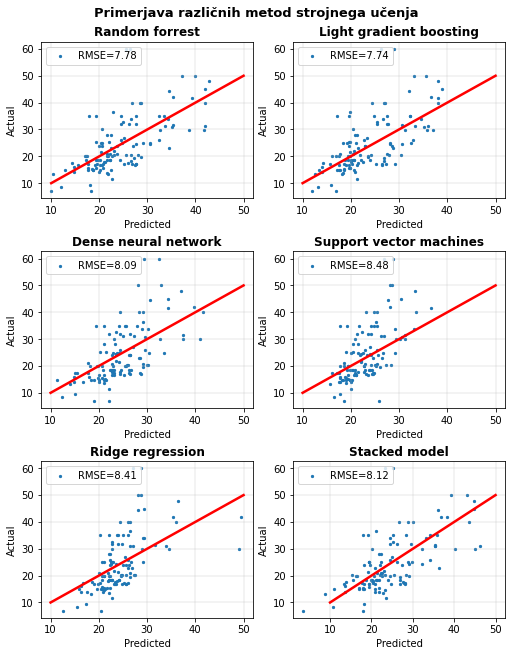

In [22]:
fig,axes=plt.subplots(3,2, figsize=(7,9),constrained_layout=True)

fig.suptitle("Primerjava različnih metod strojnega učenja",fontsize=13,fontweight="bold")

axes[0,0].scatter(pred1,y_test,label=f"RMSE={round(np.sqrt(mse(pred1,y_test.values)),2)}",s=5)
axes[0,1].scatter(pred2,y_test,label=f"RMSE={round(np.sqrt(mse(pred2,y_test)),2)}",s=5)
axes[1,0].scatter(pred3,y_test,label=f"RMSE={round(np.sqrt(mse(pred3,y_test)),2)}",s=5)
axes[1,1].scatter(pred4,y_test,label=f"RMSE={round(np.sqrt(mse(pred4,y_test)),2)}",s=5)
axes[2,0].scatter(pred5,y_test,label=f"RMSE={round(np.sqrt(mse(pred5,y_test)),2)}",s=5)
axes[2,1].scatter(final_pred,y_test,label=f"RMSE={round(np.sqrt(mse(final_pred,y_test)),2)}",s=5)

axes[0,0].set_title("Random forrest",fontweight="bold")
axes[0,1].set_title("Light gradient boosting",fontweight="bold")
axes[1,0].set_title("Dense neural network",fontweight="bold")
axes[1,1].set_title("Support vector machines",fontweight="bold")
axes[2,0].set_title("Ridge regression",fontweight="bold")
axes[2,1].set_title("Stacked model",fontweight="bold")

axes[0,0].grid(lw=0.3)
axes[0,1].grid(lw=0.3)
axes[1,0].grid(lw=0.3)
axes[1,1].grid(lw=0.3)
axes[2,0].grid(lw=0.3)
axes[2,1].grid(lw=0.3)


axes[0,0].set_xlabel("Predicted")
axes[0,1].set_xlabel("Predicted")
axes[1,0].set_xlabel("Predicted")
axes[1,1].set_xlabel("Predicted")
axes[2,0].set_xlabel("Predicted")
axes[2,1].set_xlabel("Predicted")


axes[0,0].set_ylabel("Actual")
axes[0,1].set_ylabel("Actual")
axes[1,0].set_ylabel("Actual")
axes[1,1].set_ylabel("Actual")
axes[2,0].set_ylabel("Actual")
axes[2,1].set_ylabel("Actual")

axes[0,0].legend(loc=2)
axes[0,1].legend(loc=2)
axes[1,0].legend(loc=2)
axes[1,1].legend(loc=2)
axes[2,0].legend(loc=2)
axes[2,1].legend(loc=2)

axes[0,0].plot(np.linspace(10,50,100),np.linspace(10,50,100),c="r",lw=2.5,label=f"RMSE:{round(np.sqrt(mse(pred1,y_test)),2)}")
axes[0,1].plot(np.linspace(10,50,100),np.linspace(10,50,100),c="r",lw=2.5,label=f"RMSE:{round(np.sqrt(mse(pred2,y_test)),2)}")
axes[1,0].plot(np.linspace(10,50,100),np.linspace(10,50,100),c="r",lw=2.5,label=f"RMSE:{round(np.sqrt(mse(pred3,y_test)),2)}")
axes[1,1].plot(np.linspace(10,50,100),np.linspace(10,50,100),c="r",lw=2.5,label=f"RMSE:{round(np.sqrt(mse(pred4,y_test)),2)}")
axes[2,0].plot(np.linspace(10,50,100),np.linspace(10,50,100),c="r",lw=2.5,label=f"RMSE:{round(np.sqrt(mse(pred5,y_test)),2)}")
axes[2,1].plot(np.linspace(10,50,100),np.linspace(10,50,100),c="r",lw=2.5,label=f"RMSE:{round(np.sqrt(mse(final_pred,y_test)),2)}")


Stacked model bi moral biti po pričakovanjih najuspešnejši. Tega ni opaziti, kar namiguje na to, da je prišlo do over-fittinga. Torej smo modele predobro natrenirali in dobimo lažni občutek, da so boljši, kot so v resnici.
Poleg tega nam težave povzroča tudi tako majhna količina podatkov.
Lahko si ogledamo še primerjavo, kaj se dogaja pri različnih loss-funkcijah (torej kako obtežujemo odmik posameznih 'outlierjev')

In [23]:
model = lgb.LGBMRegressor()
model.fit(X_train,y_train)
pred1 = model.predict(X_test)

model = lgb.LGBMRegressor()
model.set_params(objective="regression_l1")
model.fit(X_train,y_train)
pred2 = model.predict(X_test)

model = lgb.LGBMRegressor()
model.set_params(objective="huber")
model.fit(X_train,y_train)
pred13 = model.predict(X_test)

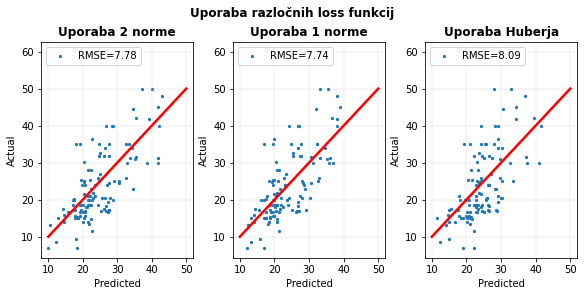

In [24]:
fig,axes=plt.subplots(1,3,figsize=(8,4),constrained_layout=True)
fig.suptitle("Uporaba razločnih loss funkcij",fontweight="bold")

axes[0].set_title("Uporaba 2 norme",fontweight="bold")
axes[1].set_title("Uporaba 1 norme",fontweight="bold")
axes[2].set_title("Uporaba Huberja",fontweight="bold")

axes[0].scatter(pred1,y_test,label=f"RMSE={round(np.sqrt(mse(pred1,y_test.values)),2)}",s=5)
axes[1].scatter(pred2,y_test,label=f"RMSE={round(np.sqrt(mse(pred2,y_test.values)),2)}",s=5)
axes[2].scatter(pred3,y_test,label=f"RMSE={round(np.sqrt(mse(pred3,y_test.values)),2)}",s=5)


axes[0].plot(np.linspace(10,50,10),np.linspace(10,50,10),lw=2.5,c="r")
axes[1].plot(np.linspace(10,50,10),np.linspace(10,50,10),lw=2.5,c="r")
axes[2].plot(np.linspace(10,50,10),np.linspace(10,50,10),lw=2.5,c="r")

axes[0].set_xlabel("Predicted")
axes[1].set_xlabel("Predicted")
axes[2].set_xlabel("Predicted")

axes[0].set_ylabel("Actual")
axes[1].set_ylabel("Actual")
axes[2].set_ylabel("Actual")

axes[0].legend(loc=2)
axes[1].legend(loc=2)
axes[2].legend(loc=2)

axes[0].grid(lw=0.2)
axes[1].grid(lw=0.2)
axes[2].grid(lw=0.2)